**Getting Started**

This tutorial relies on standard python packages as well as [SimPEG](http://simpeg.xyz). If you do not have SimPEG installed, you can uncomment the next line and install it from [pypi](https://pypi.python.org/pypi/SimPEG).

In [1]:
# !pip install SimPEG

# Simulating the 1D Magnetotelluric (MT) problem

In the [previous notebook](./MT1D_Simulation.ipynb), we walked through how to discretize and solve the 1D Magnetotelluric (MT) problem using a finite difference approach. In this notebook, we will use the numerical simulation to simulate MT data and explore concepts including
- Mesh Design: we will compare our numerical result to an analytic and see what happens when cell sizes are too large, or the domain doesn't extend far enough
- Non-uniqueness: prior to inverting geophysical data, it is important to set expectations on what we hope to recover from those data. Forward modelling is a powerful tool for getting a handle on this. 

In [2]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from SimPEG import Mesh, Utils, Solver
from scipy.constants import mu_0, epsilon_0
%matplotlib inline

In the [previous notebook](./MT1D_Simulation), we generated the function `simulateMT` in the file `MTforward.py`, we will import that and use it in this notebook. 

In [3]:
from MTforward import simulateMT

## Set up Model Parameters

To define an MT simulation, we will set up a conductivity model a frequency range over which we wish to simulate.

In [4]:
rho_half = 100.  # Resistivity of the halfspace in Ohm-m
sigma_half = 1./rho_half  # Conductivity is the inverse of conductivity

In [5]:
frequency = np.logspace(-3, 2, 25)  # frequencies at which to simulate the MT problem

## Skin depth and Mesh Design

When setting up a mesh, we want to make sure our fine cells are fine enough to capture the behaviour at the highest frequencies and that the domain extends far enough so that the fields have sufficiently decayed by the time they reach the boundary. To gauge this, we will examine the [skin depth](http://em.geosci.xyz/content/maxwell1_fundamentals/plane_waves_in_homogeneous_media/frequency/analytic_solution.html#attenuation-and-skin-depth) at the highest and lowest frequencies. Skin depth ($\delta$) is the distance at which the amplitude of an EM wave propagating through a homogeneous medium will have decayed by a factor of $1/e$

**Skin Depth**
$$
\delta = \frac{500}{\sqrt{\sigma f}}
$$

In [6]:
def skin_depth(sigma, f):
    """
    Depth at which the fields propagating through a homogeneous medium 
    have decayed by a factor of 1/e for a given frequency, f and conductivity, sigma
    """
    return 500./np.sqrt(sigma * f)

In [7]:
skin_depth_min = skin_depth(sigma_half, frequency.max())
skin_depth_max = skin_depth(sigma_half, frequency.min())

print("The minimum skin depth is {:1.2f}m".format(skin_depth_min))
print("The maximum skin depth is {:1.2e}m".format(skin_depth_max))

The minimum skin depth is 500.00m
The maximum skin depth is 1.58e+05m


### Mesh parameters

We start by choosing a mesh with parameters as follows: 
- smallest cell size: 
$$\Delta z_{\rm core} = \delta_{\rm min} / 4$$

- domain extent: 
$$z_{\rm max} = 2 \delta_{\rm max} $$

For this example, we will be exploring model variations within the top 5km, so we will extend the core region (the region of the having uniform cells with width $\Delta z_{\rm core}$) of the mesh to a depth of 5km. 

In [8]:
cs = skin_depth_min / 4.
core_extent = 5000. 
domain_extent = 2 * skin_depth_max

print("The smallest cell size is {:1.2f}m".format(cs))
print("The core region of the mesh extends {:1.2e}m".format(core_extent))
print("The mesh should extend at least {:1.2e}m".format(domain_extent))

The smallest cell size is 125.00m
The core region of the mesh extends 5.00e+03m
The mesh should extend at least 3.16e+05m


#### Padding

We will use a tensor mesh, which means we can use non-uniform cells for the padding, that is, expanding the width of the cells with depth. We can get away with this because EM fields and fluxes are diffusive and high frequencies will be attenuated as they move through the conductive earth (eg. in seismic, you wouldn't want to do this as the seismic response is  dominated by wave propagaion). 

We expand by a factor of 1.3 until we are beyond the desired domain extent. Here, we write a small `while` loop to figure out how many padding cells we should use.  

In [9]:
npad = 1  # start with 1 cell
padding_fact = 1.3  # the amount by which we will expand each cell of the padding

def padding_extent(npad):
    """
    given a number of padding cells, this computes how far the padding extends
    """
    padding_widths = cs*padding_fact**(np.arange(npad) + 1)
    return padding_widths.sum()

# keep adding padding until we are beyond the desired extent
padding_z = padding_extent(npad)
while padding_z < domain_extent:
    npad+=1
    padding_z = padding_extent(npad)
    
print("{:1.0f} padding cells extends {:1.2e}m > {:1.2e}m (2 skin depths)".format(
    npad, padding_extent(npad), domain_extent
))

25 padding cells extends 3.82e+05m > 3.16e+05m (2 skin depths)


#### Construct the Tensor mesh

Now that we have defined all of the mesh parameters, we use the [Mesh Class in SimPEG](http://docs.simpeg.xyz) to construct a mesh. This will define all of the geometries, provide the necessary differential operators, and some handy functions like plotting. 

In [10]:
ncz = np.ceil(core_extent / cs)  # number of cells in the core domain
hz = [(cs, npad, -1.3), (cs, ncz)]  # define how to construct the cell widths
mesh = Mesh.TensorMesh([hz], x0='N')  # construct a 1D Tensor Mesh

print("There are {:1.0f} cells in the mesh. The mest extends {:1.2e}m".format(
    ncz, mesh.hx.sum()
)) 

There are 40 cells in the mesh. The mest extends 3.87e+05m


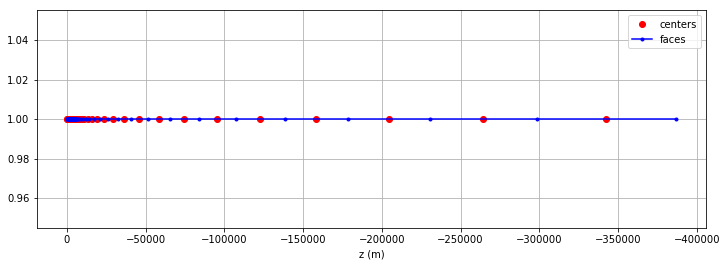

In [11]:
# plot the mesh
fig, ax = plt.subplots(1,1, figsize=(12,4))
mesh.plotGrid(centers=True, faces=True, ax=ax)
ax.legend(["centers", "faces"])
ax.invert_xaxis()  # so that the surface is on our left hand side
ax.set_xlabel('z (m)')

## Set up a model

In the [previous notebook](./MT1D_Simulation.ipynb), we showed that for a half-space, we expect the apparent resistivity computed from impedance data to be the same as the half-space resistivity, and the phase to by $45^\circ$ across the entire frequency range. 

What happens when we include a conductive target in our model?

Here we will use the following model parameters
- Resistivity of the background: $\rho_{\text{halfspace}} = 100 \Omega m$ (which is the same as $\sigma_{\text{halfspace}} = 10^{-2} S/m$)
- Resistivity of the target: $\rho_{\text{target}} = 10 \Omega m$ (which is the same as $\sigma_{\text{halfspace}} = 10^{-1} S/m$)
- Thickness of the target layer: 1000m 
- Depth of the target layer: 2000m 

In [12]:
rho_target = 10.  # resistivity in Ohm-m
depth_target = 2000.  # depth to the top of the target in m 
thickness_target = 1000.  # thickness of the target in m

In [13]:
# put the model on the mesh
sigma = 1./rho_half * np.ones(mesh.nC)

# find the indices of the layer
layer_inds = (
    (mesh.vectorCCx<=-depth_target) & 
    (mesh.vectorCCx>-(depth_target+thickness_target))
)
sigma[layer_inds] = 1./rho_target

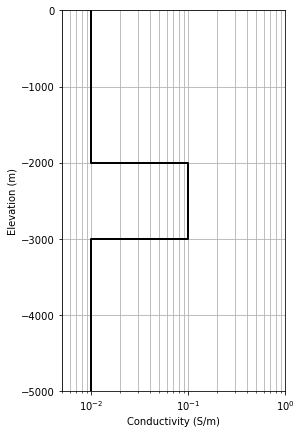

In [14]:
# plot the model
fig, ax = plt.subplots(1, 1, figsize=(4, 7))

# trickery to plot from node to node rather than at cell centers
z = np.repeat(mesh.vectorNx[1:-1], 2, axis=0)
z = np.r_[mesh.vectorNx[0], z, mesh.vectorNx[-1]]
sigma_plt = np.repeat(sigma, 2, axis=0)

ax.semilogx(sigma_plt, z, "k", lw=2)
ax.set_ylim([-5000., 0.])
ax.grid(which="both")
ax.set_xlim([5e-3, 1])
ax.set_xlabel("Conductivity (S/m)")
ax.set_ylabel("Elevation (m)")

In [25]:
depth_mid = depth_target + thickness_target / 2.

In [16]:
tsig = thickness_target * 1./rho_target
thicks = (np.arange(5)+1.)*300.
sig_targets = tsig / thicks

In [18]:
from em_examples import MT
n = 3
sig = np.r_[0., 1./rho_half, 1./rho_target, 1./rho_half]
mu = np.ones(n+1)
eps = np.ones(n+1)
chg = np.zeros(n+1)
tau = np.ones(n+1)
c = np.ones(n+1)
h = np.r_[1e5, depth_target, thickness_target]
app_res_ana, app_phase_ana = MT.appres(frequency,h,sig,chg,tau,c,mu,eps,n)
# Zxy, app_res, app_phase = MTsimulation(mesh, sigma, frequency)

In [19]:
app_res, app_phase = simulateMT(mesh, sigma, frequency)

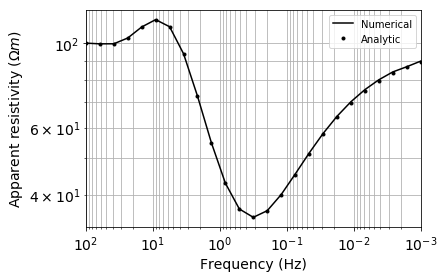

In [21]:
# figsize(5, 2)
plt.loglog(frequency, app_res, 'k-')
plt.loglog(frequency, app_res_ana, 'k.')
plt.grid(True, which='both')
plt.xlim(frequency.max(), frequency.min())
plt.xlabel("Frequency (Hz)")
plt.ylabel("Apparent resistivity ($\Omega m$)")
plt.legend(("Numerical", "Analytic"), fontsize=10)

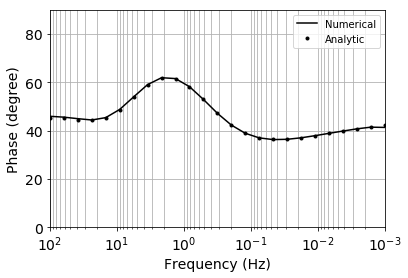

In [24]:
# figsize(5, 2)
plt.plot(frequency, app_phase, 'k-')
plt.plot(frequency, app_phase_ana, 'k.')
plt.yscale('linear')
plt.xscale('log')
plt.ylim(0, 90.) 
plt.grid(True, which='both')
plt.xlim(frequency.max(), frequency.min())
plt.xlabel("Frequency (Hz)")
plt.ylabel("Phase (degree)")
plt.legend(("Numerical", "Analytic"), fontsize=10)

In [23]:
sigmas = []
for i in range(len(thicks)):
    layer_inds = np.logical_and(mesh.vectorCCx<-depth_mid+thicks[i]*0.5, mesh.vectorCCx>-depth_mid-thicks[i]*0.5)
    sigma_temp = np.ones(mesh.nC) * 1./rho_half
    sigma_temp[layer_inds] = sig_targets[i]
    sigmas.append(sigma_temp)

In [ ]:
import matplotlib
matplotlib.rcParams["font.size"] = 11
figsize(3, 5)
for i in range(len(thicks)):
    sig_act = np.repeat(sigmas[i][actinds], 2, axis=0)
    z = np.repeat(mesh.vectorCCx[actinds][1:], 2, axis=0)
    z = np.r_[mesh.vectorCCx[actinds][0], z, mesh.vectorCCx[actinds][-1]]
    plt.plot(sig_act, z, 'k', lw=2)
plt.xscale("log")
plt.xlabel("Conductivity (S/m)")
plt.ylabel("Depth (m)")
plt.grid(True, which='both')
plt.xlim(5e-3, 1e0)

In [ ]:
APP_RES = []
APP_PHASE = []
for i in range(len(thicks)):
    Zxy, app_res, app_phase = MTsimulation(mesh, sigmas[i], frequency)
    APP_RES.append(app_res)
    APP_PHASE.append(app_phase)    

In [ ]:
figsize(5, 2)
for i in range(len(thicks)):
    plt.loglog(frequency, APP_RES[i], 'k-', alpha=(i+1)*0.2, lw=1)
plt.legend(([("t=%d m")%(thicks[i]) for i in range(5)]), fontsize = 8)
plt.grid(True, which='both')
plt.xlim(frequency.max(), frequency.min())
plt.xlabel("Frequency (Hz)")
plt.ylabel("Apparent resistivity ($\Omega m$)")

In [ ]:
figsize(5, 2)
for i in range(len(thicks)):
    plt.plot(frequency, APP_PHASE[i], 'k-', alpha=(i+1)*0.2, lw=1)
plt.yscale('linear')
plt.xscale('log')
plt.ylim(0, 90.)
plt.legend(([("t=%d m")%(thicks[i]) for i in range(5)]), fontsize = 8)
plt.grid(True, which='both')
plt.xlim(frequency.max(), frequency.min())
plt.xlabel("Frequency (Hz)")
plt.ylabel("Phase (degree)")